In [56]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [122]:
git config --global user.name "Petak14"
git config --global user.email "gerolypeter@gmail.com"

SyntaxError: invalid syntax (79843344.py, line 1)

In [57]:
df = pd.read_csv('GeneralEsportData.csv')
print("First 5 records:", df.head())

First 5 records:                     Game  ReleaseDate     Genre  TotalEarnings  \
0         Age of Empires         1997  Strategy      736284.75   
1      Age of Empires II         1999  Strategy     3898508.73   
2     Age of Empires III         2005  Strategy      122256.72   
3      Age of Empires IV         2021  Strategy     1190813.44   
4  Age of Empires Online         2011  Strategy       11462.98   

   OfflineEarnings  PercentOffline  TotalPlayers  TotalTournaments  
0        522378.17        0.709478           624               341  
1       1361409.22        0.349213          2256              1939  
2         44472.60        0.363764           172               179  
3        439117.93        0.368755           643               423  
4           775.00        0.067609            52                68  


In [58]:
# select numerical columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
numeric_cols = ['ReleaseDate', 'OfflineEarnings', 'PercentOffline', 'TotalPlayers', 'TotalTournaments']

In [59]:
# select non-numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
non_numeric_cols

array(['Game', 'Genre'], dtype=object)

In [63]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # impute values only for columns that have missing values
        med = df[col].median() #impute with the median
        df[col] = df[col].fillna(med)

numeric_cols = df_numeric.columns.tolist()
non_numeric_cols = df_non_numeric.columns.tolist()
df.head()

,Game,ReleaseDate,Genre,TotalEarnings,OfflineEarnings,PercentOffline,TotalPlayers,TotalTournaments
0,Age of Empires,1997,Strategy,736284.75,522378.17,0.709478,624,341
1,Age of Empires II,1999,Strategy,3898508.73,1361409.22,0.349213,2256,1939
2,Age of Empires III,2005,Strategy,122256.72,44472.60,0.363764,172,179
3,Age of Empires IV,2021,Strategy,1190813.44,439117.93,0.368755,643,423
4,Age of Empires Online,2011,Strategy,11462.98,775.00,0.067609,52,68


In [64]:
df.isnull().sum()

Game                0
ReleaseDate         0
Genre               0
TotalEarnings       0
OfflineEarnings     0
PercentOffline      0
TotalPlayers        0
TotalTournaments    0
dtype: int64

In [71]:
y = df['TotalEarnings']

X = df[['Game', 'Genre', 'ReleaseDate', 'OfflineEarnings', 'PercentOffline', 'TotalPlayers', 'TotalTournaments']]
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()


In [72]:
y_log = np.log1p(df['TotalEarnings'])

In [118]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, non_numeric_cols)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=355, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42))
])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
print("X_train columns:", X_train.columns.tolist())
print("ColumnTransformer numeric_cols:", numeric_cols)
print("ColumnTransformer categorical_cols:", non_numeric_cols)


X_train columns: ['Game', 'Genre', 'ReleaseDate', 'OfflineEarnings', 'PercentOffline', 'TotalPlayers', 'TotalTournaments']
ColumnTransformer numeric_cols: ['ReleaseDate', 'OfflineEarnings', 'PercentOffline', 'TotalPlayers', 'TotalTournaments']
ColumnTransformer categorical_cols: ['Game', 'Genre']


In [120]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_original_scale = np.expm1(y_pred)
mse = mean_squared_error(np.expm1(y_test), y_pred_original_scale)
rmse = np.sqrt(mse)
rmse

r2 = r2_score(np.expm1(y_test), y_pred_original_scale)

print(f"A modell pontossága: {r2 * 100:.2f}%")



A modell pontossága: 92.80%


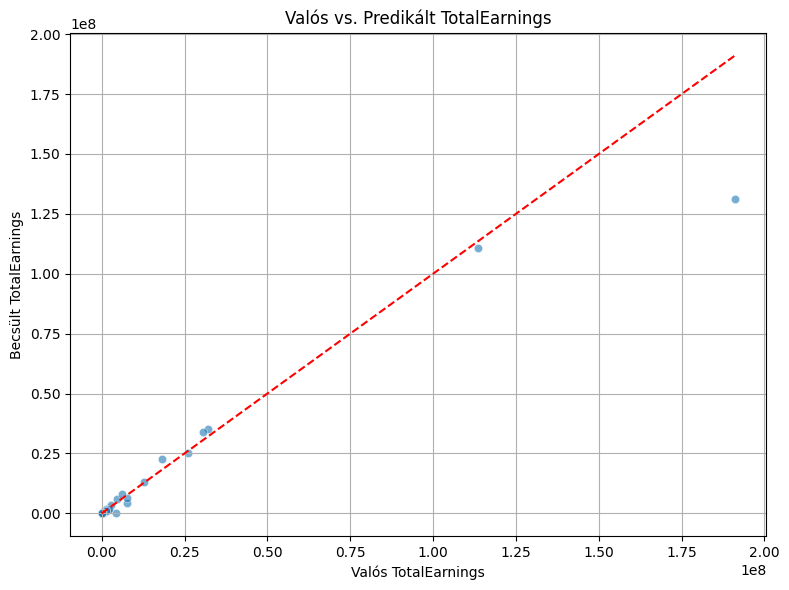

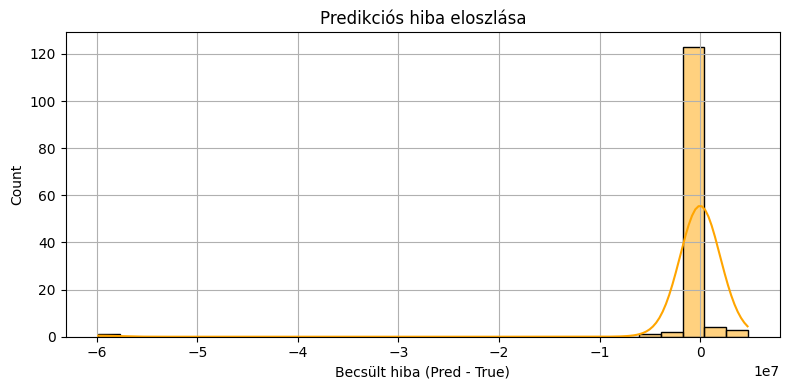

In [121]:
y_true = np.expm1(y_test)
y_pred = np.expm1(model.predict(X_test))
# === 1. SCATTER PLOT ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # paritásvonal
plt.xlabel("Valós TotalEarnings")
plt.ylabel("Becsült TotalEarnings")
plt.title("Valós vs. Predikált TotalEarnings")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. HIBA ELOSZLÁS ===
errors = y_pred - y_true
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, bins=30, color='orange')
plt.xlabel("Becsült hiba (Pred - True)")
plt.title("Predikciós hiba eloszlása")
plt.grid(True)
plt.tight_layout()
plt.show()

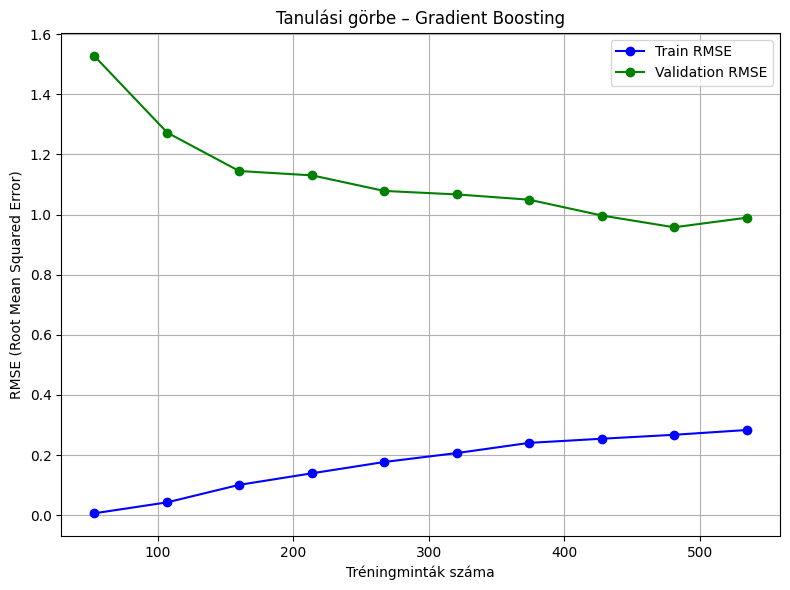

In [117]:
from sklearn.model_selection import learning_curve

# Learning curve kiszámítása
train_sizes, train_scores, val_scores = learning_curve(
    model,
    X,
    y_log,  # fontos: log-transzformált célváltozó
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Átlag és szórás számítása
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE', color='blue')
plt.plot(train_sizes, val_rmse, 'o-', label='Validation RMSE', color='green')
plt.xlabel("Tréningminták száma")
plt.ylabel("RMSE (Root Mean Squared Error)")
plt.title("Tanulási görbe – Gradient Boosting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
